In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [31]:
from fastai.vision.all import *
import fastai as fai

import numpy as np
import pandas as pd
import torch

from pathlib import Path
import json

In [3]:
torch.cuda.is_available()

True

# 1 Data

## 1.1 Setup

In [4]:
PATH = Path('carvana_data')
list(PATH.iterdir())

[Path('carvana_data/train-128'),
 Path('carvana_data/test'),
 Path('carvana_data/train_mask-128'),
 Path('carvana_data/test_hq'),
 Path('carvana_data/train'),
 Path('carvana_data/train_masks.csv'),
 Path('carvana_data/train_masks'),
 Path('carvana_data/metadata.csv'),
 Path('carvana_data/train_hq'),
 Path('carvana_data/train_mask_png')]

In [5]:
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [6]:
masks_csv = pd.read_csv(PATH/MASKS_FN)
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 885032 259 886923 308 888839 328 890754 340 892670 347 894587 352 896503 357 898420 360 900336 364 902253 367 904170 370 906086 374 908003 377 909920 379 911837 381 913754 384 915671 386 917588 388 919505 391 921422 393 923339 395 925256 397 927173 399 929090 401 931007 403 932925 404 934842 406 936759 408 938676 410 940593 412 942510 414 944428 415 946345 416 948262 418 950179 420 952097 421 954014 423 955931 425 957848 426 959766 427 961683 429 963600 431 965517 432 967435 433 969352 435 971269 437 973186 438 975104 439 977021 441 978938 442 9808...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 151 881445 13 883157 229 885062 258 886970 283 888881 309 890792 335 892705 361 894618 382 896531 393 898445 403 900359 411 902273 418 904188 424 906103 429 908018 434 909933 440 911849 443 913764 448 915680 452 917595 456 919511 460 921427 463 923343 466 925259 469 927175 472 929091 475 931007 478 932923 481 934839 484 936755 487 938672 489 940588 492 942504 495 944421 497 946337 500 948253 503 950170 505 952086 508 954002 510 955919 512 957835 515 959752 517 961668 520 963585 522 965501 525 967418 527 969334 530 971251 532 973167 535 975084 537...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 16 873887 16 875803 18 877719 21 879635 24 881551 26 883274 98 883467 29 885145 227 885383 31 887041 291 888941 322 890845 348 892752 369 894661 387 896572 402 898483 416 900394 430 902307 441 904220 452 906133 462 908046 473 909960 481 911874 490 913789 497 915703 505 917618 512 919532 520 921447 526 923362 533 925277 539 927193 544 929108 550 931023 555 932938 561 934853 567 936769 571 938684 576 940600 581 942515 586 944431 590 946346 595 948262 599 950178 603 952094 607 954009 612 955925 616 957841 620 959757 624 961673 627 963589 631 96550...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208 146 885479 33 887105 195 887394 36 889003 239 889310 38 890904 279 891225 41 892807 315 893140 44 894716 386 896624 396 898535 402 900447 408 902359 414 904271 420 906184 426 908097 439 910010 452 911923 465 913836 478 915750 489 917664 500 919577 511 921492 520 923406 530 925320 539 927235 547 929150 555 931064 564 932979 571 934894 578 936809 586 938725 591 940640 598 942555 605 944471 611 946386 618 948301 624 950217 629 952132 636 954048 641 955963 647 957879 652 959795 657 961710 663 963626 668 965542 672 967457 678 969373 683 971289 688 ...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 887160 162 887463 39 889061 197 889378 42 890964 228 891292 46 892868 257 893207 49 894773 284 895121 52 896680 308 897036 55 898588 330 898952 57 900498 349 900867 60 902409 366 902782 63 904321 441 906234 446 908147 451 910060 456 911973 461 913887 465 915800 470 917714 474 919628 478 921542 482 923456 486 925371 491 927285 498 929199 506 931114 512 933029 519 934943 526 936858 533 938773 539 940688 546 942603 552 944517 560 946432 566 948348 571 950263 578 952178 584 954093 591 956008 597 957924 602 959839 609 961755 614 963670 620 965586 626 967...


In [7]:
meta_csv = pd.read_csv(PATH/META_FN)
meta_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [8]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [9]:
CAR_ID = '00087a6bd4dc'

In [10]:
list((PATH/TRAIN_DN).iterdir())[:5]

[Path('carvana_data/train/d8f11603ef08_01.jpg'),
 Path('carvana_data/train/293a0fa72e5b_15.jpg'),
 Path('carvana_data/train/32ff007d9505_02.jpg'),
 Path('carvana_data/train/6ba36af67cb0_12.jpg'),
 Path('carvana_data/train/6bf969856536_03.jpg')]

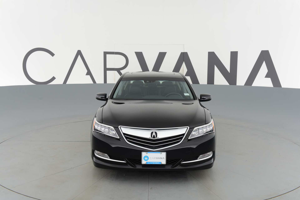

In [11]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_01.jpg').resize((300,200))

In [12]:
list((PATH/MASKS_DN).iterdir())[:5]

[Path('carvana_data/train_masks/33a310ea7462_14_mask.gif'),
 Path('carvana_data/train_masks/78bfb9c780db_06_mask.gif'),
 Path('carvana_data/train_masks/c7a94c46a3b2_07_mask.gif'),
 Path('carvana_data/train_masks/a7b9e343cf6b_02_mask.gif'),
 Path('carvana_data/train_masks/683ddec95b82_07_mask.gif')]

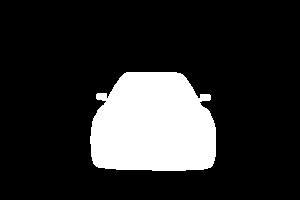

In [13]:
Image.open(PATH/MASKS_DN/f'{CAR_ID}_01_mask.gif').resize((300,200))

In [14]:
ims =[Image.open(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

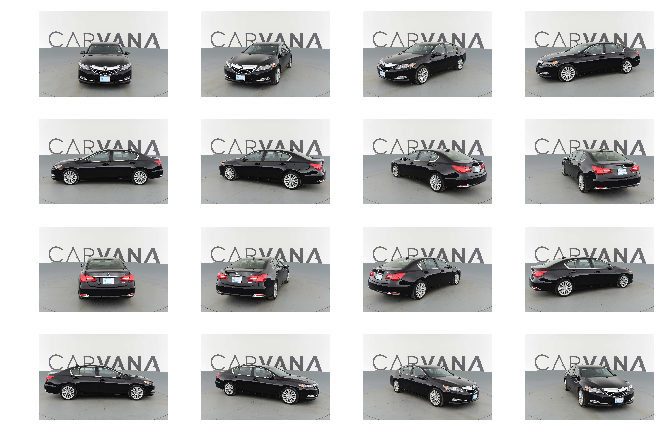

In [15]:
fig, axes = plt.subplots(4, 4, figsize=(9,6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

## 1.2 Resize and convert

Es importante convertir de .gif a .png y para este tipo de proyectos es recomendable crear una versión más compacta de los datos para hacer el trabajo más rápido.

In [19]:
(PATH/'train_mask_png').mkdir(exist_ok=True)

In [27]:
def convert_img(fn):
    fn =fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_mask_png'/f'{fn[:-4]}.png')

In [28]:
files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [29]:
(PATH/'train_mask-128').mkdir(exist_ok=True)

In [30]:
def resize_mask(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_mask-128'/fn.name)
files = list((PATH/'train_mask_png').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [31]:
(PATH/'train-128').mkdir(exist_ok=True)

In [32]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)
files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

# 2 Dataset

In [16]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_mask-128'
sz = 128
bs = 64

In [17]:
ims =[Image.open(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
im_masks = [Image.open(PATH/MASKS_DN/f'{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

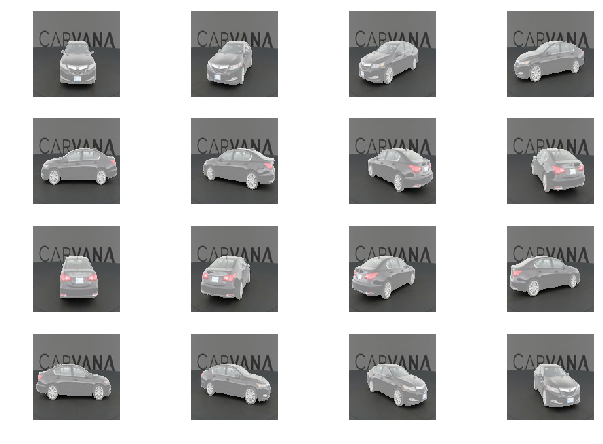

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(9,6))
for i,ax in enumerate(axes.flat): 
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

minuto del video: 1:35:56

In [37]:
class MatchedFilesDataset():
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self,i): return Image.open(os.path.join(delf.path, self.y[i]))
    def get_c(self): return 0

In [33]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [34]:
len(x_names)//16//5*16

1008

In [41]:
valid_idxs = list(range(1008))
#((val_x, trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
#len(val_x),len(trn_x)